# Creative Machine Learning Experiments on the Metatone Data

In this notebook, I'll work on some ML experiments with the Metatone performance data. The goal is to create models of these performances that are more realistic than the first order models used in earlier experiments.

In [1]:
from __future__ import print_function
import os
import time
import pandas as pd
import numpy as np
import tensorflow as tf
import time
import os
import datetime
import pickle
from sklearn import datasets, metrics, cross_validation
import matplotlib.pyplot as plt
import random

URL = "https://github.com/anucc/metatone-analysis/raw/master/metadata/"
PICKLE_FILE = "metatone_performances_dataframe.pickle"

if not os.path.exists(PICKLE_FILE):
    urlretrieve(URL + PICKLE_FILE, PICKLE_FILE)

with open(PICKLE_FILE, 'rb') as f:
        metatone_dataset = pickle.load(f)
        
## Int values for Gesture codes.
NUMBER_GESTURES = 9
GESTURE_CODES = {
    'N': 0,
    'FT': 1,
    'ST': 2,
    'FS': 3,
    'FSA': 4,
    'VSS': 5,
    'BS': 6,
    'SS': 7,
    'C': 8}

## Descriptive Statistics of the dataset

Number of records: 72
Min performers: 2 Max performers: 9
Total performer-records: 252


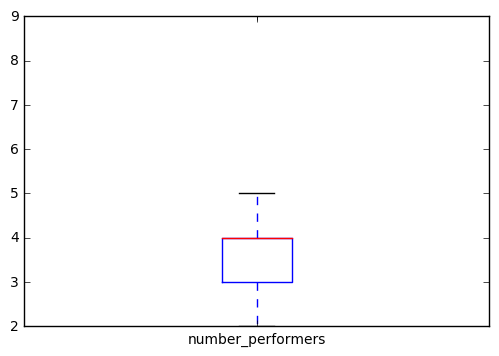

In [2]:
improvisations = metatone_dataset[
    (metatone_dataset["performance_type"] == "improvisation") &
    (metatone_dataset["performance_context"] != "demonstration")]

#print(str(improvisations["performance_type"].unique()))
#print(str(improvisations["performance_context"].unique()))

print("Number of records: " + str(improvisations["number_performers"].count()))
print("Min performers: " + str(improvisations["number_performers"].min()) + " Max performers: "+ str(improvisations["number_performers"].max()))
print("Total performer-records: " + str(improvisations["number_performers"].sum()))


performers = improvisations["number_performers"].plot(kind="box")
plt.show(performers)


## Process Data

Isolate the gesture arrays and process them.

In [3]:
gesture_data = improvisations['gestures']
individual_improvisations = []


for perf in gesture_data.tolist():
    for one_perf in perf.T:
        individual_improvisations.append(one_perf)

print("Dataset contains " + str(len(individual_improvisations)) + " individual improvisations.")

vocabulary_size = len(GESTURE_CODES)

def code_to_one_hot(code):
    output = np.zeros((vocabulary_size,),dtype=np.int)
    output[code] += 1
    return output

def one_hot_to_code(vec):
    return 0


Dataset contains 252 individual improvisations.


## Segment and Prepare the Data

Segment the data into inputs and output list of length `num_steps`. Each record in the data is sliced into as many such lists as possible and the total size of the corpus is printed out for reference.

In [8]:
## Setup the epochs
def generate_epochs(num_epochs, num_steps, batch_size):
    ## Setup the inputs and label sets
    imp_xs = []
    imp_ys = []

    for imp in individual_improvisations:
        for i in range(len(imp)-num_steps-1):
            imp_x = imp[i:i+num_steps]
            imp_y = imp[i+1:i+num_steps+1]
            imp_xs.append(imp_x)
            imp_ys.append(imp_y)
    
    dataset = zip(imp_xs,imp_ys)
    print("Total Training Examples: " + str(len(imp_xs)))
    print("Total Training Labels: " + str(len(imp_ys)))
    epochs = []
    for j in range(num_epochs):
        # shutffle the big list
        np.random.shuffle(dataset)
        dataset_size = len(dataset)
        batches = []
        for i in range(dataset_size / batch_size):
            ## Setup the batches
            batch = dataset[i*batch_size:(i+1)*batch_size]
            bx,by = zip(*batch)
            batches.append((np.array(bx),np.array(by)))
        epochs.append(batches)
    return epochs


# Test 
#a = generate_epochs(2,10,20)
#e1 = a[0]
#e2 = a[1]
#print(len(e1))
#print(len(e2))
#print(e1[0][0].shape)

## Simple LSTM Model

Setup a simple 3-Layer LSTM Model with 64 nodes in each layer.

In [9]:
num_nodes = 64
num_classes = vocabulary_size
batch_size = 64
num_steps = 50
num_layers = 3
learning_rate = 1e-4
  
#graph = tf.Graph()
graph = tf.get_default_graph()
with graph.as_default():
    x = tf.placeholder(tf.int32,[batch_size,num_steps], name='input_placeholder')
    y = tf.placeholder(tf.int32,[batch_size,num_steps], name='labels_placeholder')
    embeddings = tf.get_variable('embedding_matrix', [num_classes, num_nodes])
    rnn_inputs = tf.nn.embedding_lookup(embeddings,x)
    
    # Define the network
    cell = tf.nn.rnn_cell.LSTMCell(num_nodes,state_is_tuple=True)
    cell = tf.nn.rnn_cell.MultiRNNCell([cell] * num_layers, state_is_tuple=True)
    init_state = cell.zero_state(batch_size,tf.float32)
    rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, initial_state=init_state)
    
    with tf.variable_scope('softmax'):
        W = tf.get_variable('W',[num_nodes,num_classes])
        b = tf.get_variable('b',[num_classes], initializer=tf.constant_initializer(0.0))
       
    rnn_outputs = tf.reshape(rnn_outputs,[-1,num_nodes])
    y_reshaped = tf.reshape(y,[-1])
    
    logits = tf.matmul(rnn_outputs, W) + b
    predictions = tf.nn.softmax(logits)
    
    total_loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, y_reshaped))
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)


In [10]:
x

<tf.Tensor 'input_placeholder:0' shape=(64, 50) dtype=int32>

In [11]:
y

<tf.Tensor 'labels_placeholder:0' shape=(64, 50) dtype=int32>

## Train the Model

In [ ]:
num_epochs = 1
tf.set_random_seed(2345)

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    training_losses = []
    print("Starting Training")
    for epoch in generate_epochs(num_epochs, num_steps, batch_size):
        ## Setup for each epoch
        training_loss = 0
        steps = 0
        training_state = None
        print("Starting an Epoch.")
        for batch_data, batch_labels in epoch:
            #print(batch_data.shape)
            #print(batch_labels.shape)
            ## Setup for each batch
            feed = {x:batch_data, y:batch_labels}
            if training_state is not None:
                feed[init_state] = training_state
            #print(str(feed))
            ## Evaluate the train step
            training_loss_current, training_state, _ = sess.run([total_loss,final_state,train_step],feed_dict=feed)
            steps += 1
            training_loss += training_loss_current
            print("Trained a batch, loss was: " + str(training_loss_current))
        print("Trained ")
        training_losses.append(training_loss/steps)
    ## Save the results
    tf.train.Saver()

Starting Training
Starting an Epoch.
(64, 50)
(64, 50)
{<tf.Tensor 'input_placeholder:0' shape=(64, 50) dtype=int32>: array([[1, 1, 1, ..., 1, 1, 1],
       [5, 5, 6, ..., 0, 0, 2],
       [3, 7, 7, ..., 3, 3, 3],
       ..., 
       [0, 0, 0, ..., 2, 2, 2],
       [4, 4, 7, ..., 2, 2, 0],
       [0, 0, 0, ..., 0, 0, 0]]), <tf.Tensor 'labels_placeholder:0' shape=(64, 50) dtype=int32>: array([[1, 1, 1, ..., 1, 1, 1],
       [5, 6, 7, ..., 0, 2, 2],
       [7, 7, 7, ..., 3, 3, 3],
       ..., 
       [0, 0, 0, ..., 2, 2, 2],
       [4, 7, 7, ..., 2, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])}
Trained a batch, loss was: 2.16981
(64, 50)
(64, 50)
{<tf.Tensor 'input_placeholder:0' shape=(64, 50) dtype=int32>: array([[6, 2, 2, ..., 8, 7, 7],
       [4, 7, 7, ..., 2, 0, 2],
       [2, 2, 1, ..., 2, 2, 2],
       ..., 
       [1, 1, 1, ..., 1, 1, 1],
       [3, 3, 3, ..., 8, 3, 3],
       [7, 4, 7, ..., 7, 7, 7]]), <tf.Tensor 'labels_placeholder:0' shape=(64, 50) dtype=int32>: array([[2, 2, 2, ..